In [272]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#
# Project 2, starter code Part a
#

import math
import tensorflow as tf
import numpy as np
import pylab as plt
import pickle

In [0]:
NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 1000
batch_size = 128

seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

In [0]:
def load_data(file):
  with open(file, 'rb') as fo:
      try:
          samples = pickle.load(fo)
      except UnicodeDecodeError:  #python 3.x
          fo.seek(0)
          samples = pickle.load(fo, encoding='latin1')

  data, labels = samples['data'], samples['labels']

  data = np.array(data, dtype=np.float32)
  labels = np.array(labels, dtype=np.int32)


  labels_ = np.zeros([labels.shape[0], NUM_CLASSES])
  labels_[np.arange(labels.shape[0]), labels-1] = 1

  return data, labels_

In [0]:
def cnn(images):
  images = tf.reshape(images, [-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])

  # C1 (50x24x24): Conv layer, 50 filters, window size 9x9, VALID padding, ReLU
  # S1 (50x12x12): Max pooling layer, window size 2x2, stride = 2, VALID padding
  W1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, 50], stddev=1.0/np.sqrt(NUM_CHANNELS*9*9)), name='weights_1')
  b1 = tf.Variable(tf.zeros([50]), name='biases_1')  
  conv_1 = tf.nn.relu(tf.nn.conv2d(images, W1, [1, 1, 1, 1], padding='VALID') + b1)
  pool_1 = tf.nn.max_pool(conv_1, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_1')

  # C2 (60x8x8): Conv layer, 60 filters, window size 5x5, VALID padding, ReLU
  # S2 (60x4x4): Max pooling layer, window size 2x2, stride = 2, VALID padding
  W2 = tf.Variable(tf.truncated_normal([5, 5, 50, 60], stddev=1.0/np.sqrt(50*5*5)), name='weights_2')
  b2 = tf.Variable(tf.zeros([60]), name='biases_2')
  conv_2 = tf.nn.relu(tf.nn.conv2d(pool_1, W2, [1, 1, 1, 1], padding='VALID') + b2)
  pool_2 = tf.nn.max_pool(conv_2, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_2')

  # Flatten (dim = 60x4x4 = 960)
  dim = pool_2.get_shape()[1].value * pool_2.get_shape()[2].value * pool_2.get_shape()[3].value 
  pool_2_flat = tf.reshape(pool_2, [-1, dim])

  # F3: Fully connected layer of size 300 (960 -> 300)
  W3 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0/np.sqrt(dim)), name='weights_3')
  b3 = tf.Variable(tf.zeros([300]), name='biases_3')
  f3_logits = tf.matmul(pool_2_flat, W3) + b3

  # F4: Softmax layer of size 10 (300 -> 10)
  W4 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0/np.sqrt(dim)), name='weights_4')
  b4 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_4')
  f4_logits = tf.matmul(f3_logits, W4) + b4

  return conv_1, pool_1, conv_2, pool_2, f4_logits

(10000, 3072) (10000, 10)
(2000, 3072) (2000, 10)
Epoch:  0  | Train loss:  2.2995172  | Test acc:  0.103
Epoch:  10  | Train loss:  2.2687364  | Test acc:  0.188
Epoch:  20  | Train loss:  2.2193062  | Test acc:  0.2415
Epoch:  30  | Train loss:  2.1298723  | Test acc:  0.2835
Epoch:  40  | Train loss:  2.0400758  | Test acc:  0.286
Epoch:  50  | Train loss:  1.9759884  | Test acc:  0.3065
Epoch:  60  | Train loss:  1.9310571  | Test acc:  0.3085
Epoch:  70  | Train loss:  1.9008877  | Test acc:  0.309
Epoch:  80  | Train loss:  1.8800509  | Test acc:  0.317
Epoch:  90  | Train loss:  1.8623801  | Test acc:  0.323
Epoch:  100  | Train loss:  1.8457925  | Test acc:  0.331
Epoch:  110  | Train loss:  1.8316882  | Test acc:  0.342
Epoch:  120  | Train loss:  1.8144171  | Test acc:  0.347
Epoch:  130  | Train loss:  1.7978367  | Test acc:  0.353
Epoch:  140  | Train loss:  1.78152  | Test acc:  0.3635
Epoch:  150  | Train loss:  1.7649872  | Test acc:  0.361
Epoch:  160  | Train loss:  1.

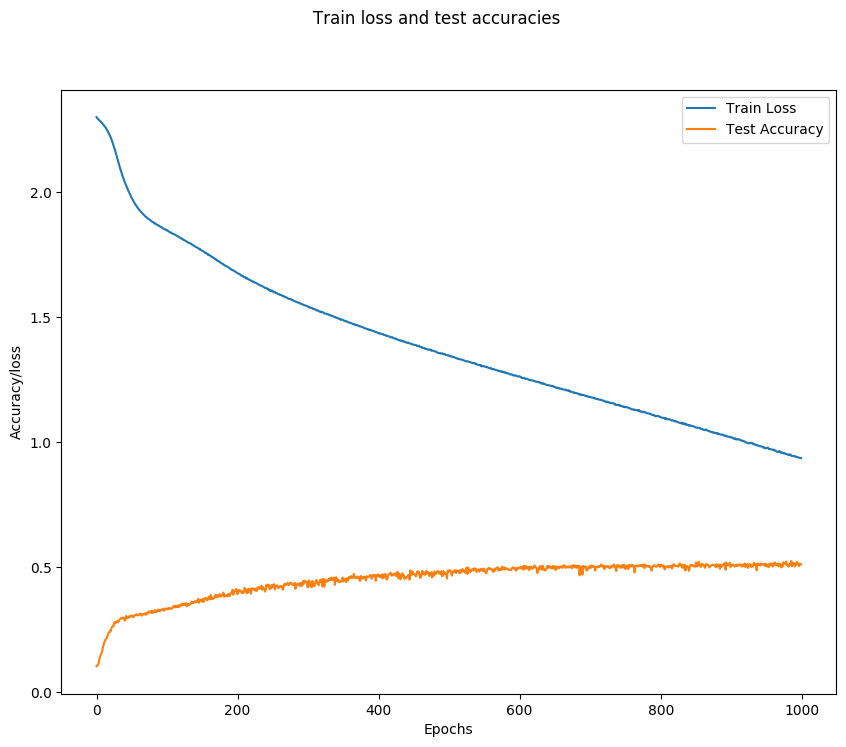

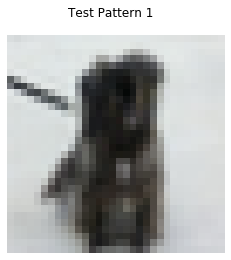

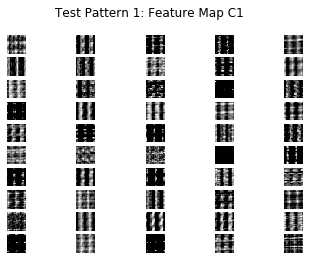

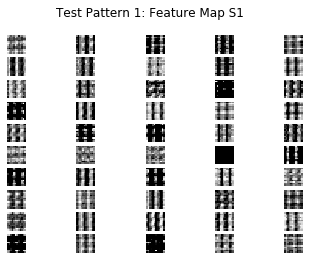

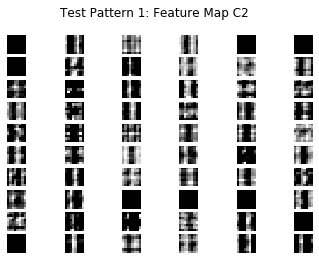

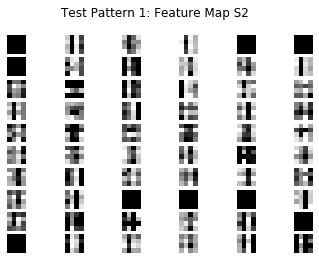

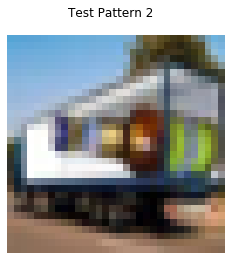

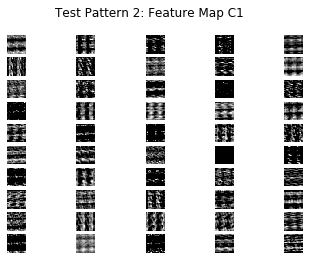

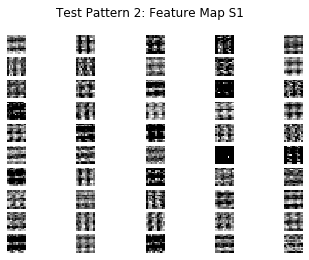

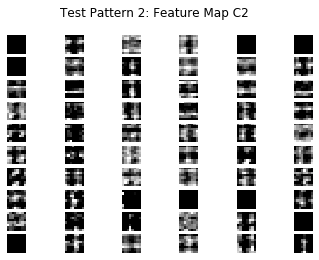

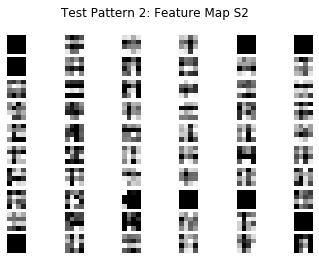

In [277]:
# Main Program
if __name__ == '__main__':
  trainX, trainY = load_data('/content/drive/My Drive/NTU - Year 3 Sem 1/CZ4042 Neural Network/Project 2/data_batch_1')
  print(trainX.shape, trainY.shape)

  testX, testY = load_data('/content/drive/My Drive/NTU - Year 3 Sem 1/CZ4042 Neural Network/Project 2/test_batch_trim')
  print(testX.shape, testY.shape)

  # Scaling the train & test inputs
  trainX = (trainX - np.min(trainX, axis = 0))/np.max(trainX, axis = 0)
  testX = (testX - np.min(testX, axis = 0))/np.max(testX, axis = 0)

  # Create the model
  x = tf.placeholder(tf.float32, [None, NUM_CHANNELS*IMG_SIZE*IMG_SIZE]) # 3x32x32
  y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

  c1, s1, c2, s2, logits = cnn(x)

  cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
  loss = tf.reduce_mean(cross_entropy)

  train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
  correct_prediction = tf.cast(correct_prediction, tf.float32)
  accuracy = tf.reduce_mean(correct_prediction)

  N = len(trainX)
  idx = np.arange(N)

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_loss = []
    test_acc = []

    for e in range(epochs):
      np.random.shuffle(idx)
      trainX, trainY = trainX[idx], trainY[idx]
      temp_train_loss = []

      for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
        train_step.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})
        temp_train_loss.append(loss.eval(feed_dict={x: trainX[start:end], y_: trainY[start:end]}))

      # _, loss_ = sess.run([train_step, loss], {x: trainX, y_: trainY})

      trainLoss = np.mean(np.array(temp_train_loss))
      testAcc = accuracy.eval(feed_dict={x: testX, y_: testY})
      train_loss.append(trainLoss)
      test_acc.append(testAcc)

      if (e % 10 == 0 or e == epochs-1):
        print('Epoch: ', e, ' | Train loss: ', trainLoss, ' | Test acc: ', testAcc)

    # Plot train loss vs test acc
    plt.figure(figsize=(10, 8), dpi= 100)
    plt.suptitle('Train loss and test accuracies')
    plt.plot(range(epochs), train_loss, label='Train Loss')
    plt.plot(range(epochs), test_acc, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy/loss')
    plt.savefig('./1a.TrainLoss_TestAcc.png')
    plt.legend()
    plt.show()

    # Plots
    for i in range(2):
      # ind = np.random.randint(low=0, high=10000)

      # Test Patterns
      plt.figure()
      plt.suptitle('Test Pattern %d' %(i+1))
      plt.gray()
      plt.axis('off')
      X = testX[i,:]
      X_show = X.reshape(NUM_CHANNELS, IMG_SIZE, IMG_SIZE).transpose(1, 2, 0)
      plt.imshow(X_show)
      plt.savefig('./1b.TP%d_Original.png' %(i+1))

      # Feature Maps
      def plotFeatureMap(layer, tpNum, layerText):
        plt.figure()
        plt.suptitle('Test Pattern {}: Feature Map {}'.format(tpNum+1, layerText))
        plt.gray()
        layer_show = layer[0].transpose(2, 0, 1)
        for j in range(len(layer_show)):
          if (len(layer_show) == 50):
            plt.subplot(10, 5, j+1)
          elif (len(layer_show) == 60):
            plt.subplot(10, 6, j+1)
          plt.axis('off')
          plt.imshow(layer_show[j])
        plt.savefig('./1b.TP{}_FM_{}.png'.format(tpNum+1, layerText))

      c1_, s1_, c2_, s2_ = sess.run([c1, s1, c2, s2],{x: testX[i,:].reshape(1,3072)})
      plotFeatureMap(c1_, i, 'C1')
      plotFeatureMap(s1_, i, 'S1')
      plotFeatureMap(c2_, i, 'C2')
      plotFeatureMap(s2_, i, 'S2')

    plt.show()